In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)

import figa as figa
from joblib import dump, load
from sklearn.metrics import (
    roc_curve,
    RocCurveDisplay,
    roc_auc_score,
    PrecisionRecallDisplay,
    precision_recall_curve,
)
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
data = pd.read_csv("checkxss.csv")
y = data["Class"]
X = data.drop(labels=["Class"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [4]:
results = {
    "e": [],
    "n": [],
    "mpd_threshold": [],
    "classifier_attack_success_rate": [], # todo: PDC is phishing detection classifier, change the name 
    "MPD_detection_rate":[],
    
    
}


In [5]:
malware_set = X_test[y_test == 1]

# taking a portion of the  X_test samples to perform attack
X_test_50p_malware = malware_set.sample(frac=0.5)

# making the same portion of X_test as value label 1 in y_test
y_adver = y_test.copy()
y_adver[X_test_50p_malware.index] = 2

y_adver[y_adver == 0] = 0
y_adver[y_adver == 1] = 0
y_adver[y_adver == 2] = 1  

threshold = np.linspace(0.01, 0.76, 50) #mpd threshold

clf = DecisionTreeClassifier(max_depth = 17,min_samples_leaf=2,min_samples_split=13, criterion='entropy')
mpd = load("xss.joblib")
clf.fit(X_train, y_train)


# no attack
#mpd_scores_no_attack = mpd.get_mpd_score(X_test)




attack_featuresfull = figa.FeatureImportanceAttack(X_train, y_train) 

#for loop is to check how the attack and model prediction for every n value
#goal: to measure FIGA attack success rate as n varies 
        # to measure MPD detection rate as n varies 
      # MPD threshold value as n varies
for n in range(len(data.columns)):
    
    # generate adversarial samples with n value  from FIGA 
    
    attack_sample_generated = attack_featuresfull.generate( X_test_50p_malware, y_test[X_test_50p_malware.index], 2.24, n) 
    
    ####check which generated samples are succesful at evading: #####
 
  #step1: get predictions from  detection model
    malware_predict= clf.predict(attack_sample_generated) #malware samples prediction 
    
    #step2: compare original labels to predicted labels
    
    #step2.1: getting the original labels
    y_malware=y_test[X_test_50p_malware.index] #original labels 
    
    #step2.2: selecting the esessful adversarial generted samples
    succ_adv_samples=attack_sample_generated[(y_malware == 1) & (malware_predict == 0)] #testing for succesful samples that evaded the model #todo: select it to perturbed ones 
    
    #### record attack success rate: 
    attack_success_rate=1-recall_score(y_malware, malware_predict)
    results["classifier_attack_success_rate"].append(attack_success_rate)

    results["e"].append(2.24)
    results["n"].append(n)
    
    ### get MPD detection and threshold value
    
    #step3: find optimal threshold value: 
    #step3.1: we have to generate the data and get mpd score
    
    X_adv_testbed = X_test.copy()
    
    #insert successful adversarial samples and get mpd scores
    X_adv_testbed.update(succ_adv_samples) 
    mpd_scores_attack = mpd.get_mpd_score(X_adv_testbed)
    
    y_adv_sucess=y_test.copy()
    y_adv_sucess[y_test.index]=0
    y_adv_sucess[succ_adv_samples.index]=1
    
   # mpd_scores_detect=mpd.get_mpd_score(succ_samples) #getting mpd scores of only successful model
    
    # finding the best threshold/ f1score / precision / recall -  for each n loop
    f1_scores = []
    recall_scores = []
    precision_scores = []
    confusion_matrices = []
    mpd_f1_scores = [] #detection f1 score of succesful samples 

    for thres in threshold:
        mpd_pred = mpd_scores_attack.copy()
        mpd_pred[mpd_pred > thres] = 1
        mpd_pred[mpd_pred <= thres] = 0
        # threshold_values.append(thres)
        f1_scores.append(f1_score(y_adv_sucess, mpd_pred))
        
      #  mpd_f1_scores.append(f1_score(fp_ytest, fp_predit))
        
        recall_scores.append(recall_score(y_adv_sucess, mpd_pred))
        precision_scores.append(precision_score(y_adv_sucess, mpd_pred))
        confusion_matrices.append(confusion_matrix(y_adv_sucess, mpd_pred))
        
      
    
    
    best_f1 = np.max(f1_scores)
    best_index = np.argmax(f1_scores)
    threshold_used = threshold[best_index]
    best_precision = precision_scores[best_index]
    best_recall = recall_scores[best_index]
    best_confusion_matrix = confusion_matrices[best_index]
    mpd_tn, mpd_fp, mpd_fn, mpd_tp = best_confusion_matrix.ravel()


    results["mpd_threshold"].append(threshold_used)

    ### get mpd success rate
    bestmpd_pred = mpd_scores_attack.copy()
    bestmpd_pred[bestmpd_pred > threshold_used] = 1
    bestmpd_pred[bestmpd_pred <= threshold_used] = 0
    
    mpd_detection_rate=recall_score(y_adv_sucess,bestmpd_pred)
    results["MPD_detection_rate"].append(mpd_detection_rate)
    detection_success_rate= {1 - mpd_detection_rate}
   

Storing the results in dataframe format and to csv file
----------------------------------------------------------

In [6]:
df_results = pd.DataFrame(results)

df_results.to_csv("xss_results.csv")

In [7]:
df = pd.read_csv('xss_results.csv', index_col=0)
df.head()

,e,n,mpd_threshold,classifier_attack_success_rate,MPD_detection_rate
0,2.24,0,0.377347,0.007018,0.875000
1,2.24,1,0.377347,0.020175,0.608696
2,2.24,2,0.331429,0.021491,0.632653
3,2.24,3,0.147755,0.064474,0.925170
4,2.24,4,0.132449,0.076754,0.937143


Plotting MPD performance on XSS dataset for every number of features (n)
---------------------------------------------------------------------------

Text(0.5, 1.0, 'MPD Performance on XSS dataset')

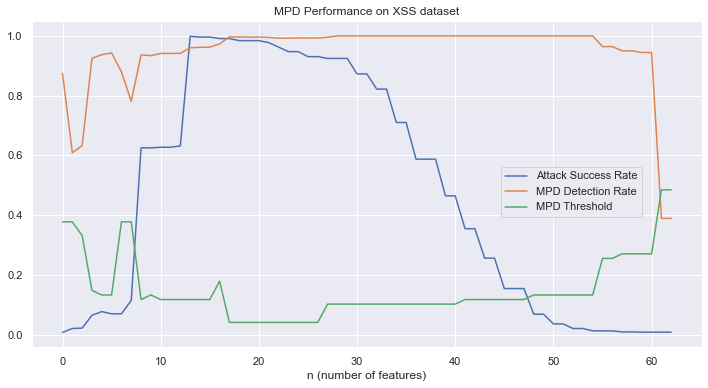

In [8]:
df.plot(x='n', y=['classifier_attack_success_rate','MPD_detection_rate', "mpd_threshold"], figsize = (12,6));
plt.legend(labels =['Attack Success Rate','MPD Detection Rate', "MPD Threshold"] , loc = (0.70,0.4))
plt.xlabel("n (number of features)")
plt.title("MPD Performance on XSS dataset")